In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from util import load_data

from lifelines import KaplanMeierFitter as KM
from lifelines.statistics import logrank_test

In [2]:
from lifelines.datasets import load_lymphoma


def load_data():
    df = load_lymphoma()
    df.loc[:, 'Event'] = df.Censor
    df = df.drop(['Censor'], axis=1)
    return df

data = load_data()

In [3]:
print("data shape: {}".format(data.shape))
data.head()

data shape: (80, 3)


,Stage_group,Time,Event
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1


## Censored Data

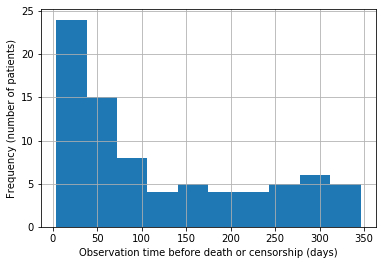

In [4]:
data.Time.hist();
plt.xlabel("Observation time before death or censorship (days)");
plt.ylabel("Frequency (number of patients)");


In [5]:
def frac_censored(df):
    result = 0.0
    result = 1 - sum(df['Event'] == 1) / len(df)
    
    return result
    
print(frac_censored(data))

0.32499999999999996


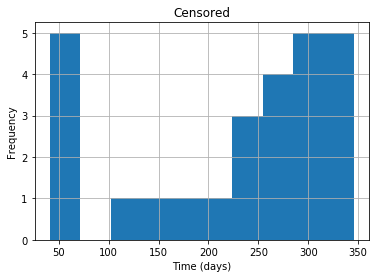

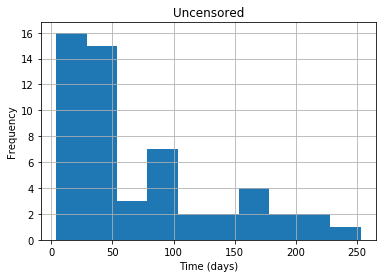

In [6]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

### Survival Estimates

In [7]:
def naive_estimator(t, df):
    S_t = 0.0
    nr = sum((df['Time'] > t))
    dr = sum((df['Event'] == 0) | (df['Time'] > t))
    
    S_t = nr / dr
    return S_t

In [8]:
print("Test Cases")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print("Sample dataframe for testing code:")
print(sample_df)
print("\n")

print("Test Case 1: S(3)")
print("Output: {}, Expected: {}\n".format(naive_estimator(3, sample_df), 1.0))

print("Test Case 2: S(12)")
print("Output: {}, Expected: {}\n".format(naive_estimator(12, sample_df), 0.5))

print("Test Case 3: S(20)")
print("Output: {}, Expected: {}\n".format(naive_estimator(20, sample_df), 0.0))

# Test case 4
sample_df = pd.DataFrame({'Time': [5,5,10],
                          'Event': [0,1,0]
                         })
print("Test case 4: S(5)")
print(f"Output: {naive_estimator(5, sample_df)}, Expected: 0.5")

Test Cases
Sample dataframe for testing code:
   Time  Event
0     5      0
1    10      1
2    15      0


Test Case 1: S(3)
Output: 1.0, Expected: 1.0

Test Case 2: S(12)
Output: 0.5, Expected: 0.5

Test Case 3: S(20)
Output: 0.0, Expected: 0.0

Test case 4: S(5)
Output: 0.5, Expected: 0.5


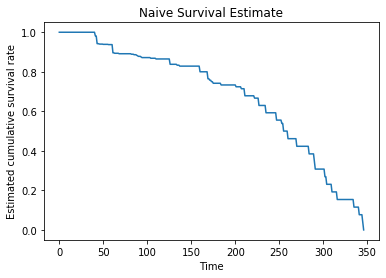

In [9]:
max_time = data.Time.max()
x = range(0, max_time + 1)
y = np.zeros(len(x))
for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y)
plt.title("Naive Survival Estimate")
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

In [10]:
def HomemadeKM(df):
    event_times = [0]
    p = 1.0
    S = [p]
    
    observed_event_times = df['Time'].unique()
    observed_event_times = np.sort(observed_event_times)
    
    for t in observed_event_times:
        # compute n_t, number of people who survive to time t
        n_t = sum(df['Time'] >= t)
  
        # compute d_t, number of people who die at time t
        d_t = sum((df['Time'] == t) & (df['Event'] == 1))
        
        # update p
        p =p * ( 1 - ( d_t / n_t))
  
        # update S and event_times (ADD code below)
        # hint: use append
        S.append(p)
        event_times.append(t)
        
    return event_times, S

In [11]:
print("TEST CASES:\n")


print("Test Case 1\n")

print("Test DataFrame:")
sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]")

print("\nTest Case 2\n")

print("Test DataFrame:")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.loc[:, "Time"] = [2, 15, 12, 10, 20]
sample_df.loc[:, "Event"] = [0, 0, 1, 1, 1]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]")

TEST CASES:

Test Case 1

Test DataFrame:
   Time  Event
0     5      0
1    10      1
2    15      0

Output:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Expected:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Test Case 2

Test DataFrame:
   Time  Event
0     2      0
1    15      0
2    12      1
3    10      1
4    20      1

Output:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]

Expected:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]


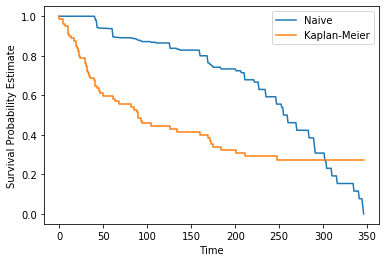

In [12]:
max_time = data.Time.max()
x = range(0, max_time + 1)
y = np.zeros(len(x))

for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y, label='Naive')

x, y = HomemadeKM(data)
plt.step(x, y, label='Kaplan-Meier')
plt.xlabel('Time')
plt.ylabel('Survival Probability Estimate')
plt.legend()
plt.show()

### Subgroup Analysis

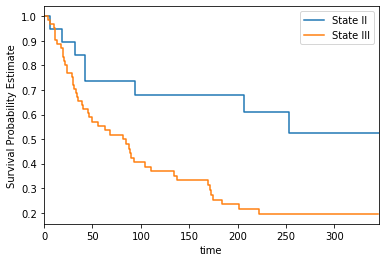

In [13]:
S1 = data[data.Stage_group == 1]
km1 = KM()
km1.fit(
    S1.loc[:, 'Time'], event_observed=S1.loc[:, 'Event'], label='State II'
)

S2 = data[data.Stage_group == 2]
km2 = KM()
km2.fit(
    S2.loc[:, 'Time'], event_observed=S2.loc[:, 'Event'], label='State III'
)

ax = km1.plot(ci_show=False)
km2.plot(ax=ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival Probability Estimate')
plt.savefig('two_km_curves', dpi=300)

In [14]:
survivals = pd.DataFrame([90, 180, 270, 360], columns=['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [15]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


### Log Rank Test

In [16]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(
        group_1_data.Time, group_2_data.Time,
        group_1_data.Event, group_2_data.Event
    )
    return result.p_value

In [17]:
logrank_p_value(S1, S2)

0.009588929834755544